##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic classification: Classify images of clothing

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This guide trains a neural network model to classify images of clothing, like sneakers and shirts. It's okay if you don't understand all the details; this is a fast-paced overview of a complete TensorFlow program with the details explained as you go.

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

print(tf.__version__)

2.0.0


This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:


Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and load the Fashion MNIST data directly from TensorFlow:

In [76]:
train_input = np.load('train_input_symmetry_adapted_equal_alpha_beta_quenched.npy')
train_labels = np.load('train_input_symmetry_adapted_equal_alpha_beta_quenched_labels.npy')
test_labels = np.load('test_input_symmetry_adapted_equal_quenched_labels.npy')
test_input = np.load('test_input_symmetry_adapted_equal_quenched.npy')

Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>alpha</td>
  </tr>
  <tr>
    <td>1</td>
    <td>beta</td>
  </tr>  <tr>
    <td>2</td>
    <td>quenched</td>
  </tr>
    
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [77]:
classifications = ['alpha', 'beta', 'quenched']

## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 51,000 parameters in the training set, each with 26 components:

In [5]:
train_input.shape

(32400, 6)

Likewise, there are 51,000 labels in the training set:

In [6]:
len(train_labels)

32400

Each label is an integer between 0 and 1:

In [7]:
train_labels

array([0., 0., 0., ..., 2., 2., 2.])

There are 50,000 images in the test set. Again, each image is represented as 26 components:

In [8]:
test_input.shape

(10800,)

And the test set contains 50,000 images labels:

In [9]:
len(test_labels)

10800

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The basic building block of a neural network is the *layer*. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of machine learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

In [78]:
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer is a 10-node *softmax* layer that returns an array of 10 probability scores that sum to 1. Each node contains a score that indicates the probability that the current image belongs to one of the 10 classes.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:

* *Loss function* —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* *Optimizer* —This is how the model is updated based on the data it sees and its loss function.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [79]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. You ask the model to make predictions about a test set—in this example, the `test_images` array. Verify that the predictions match the labels from the `test_labels` array.

To start training,  call the `model.fit` method—so called because it "fits" the model to the training data:

In [ ]:
start1 = time.time()
model.fit(train_input, train_labels, epochs=10)
end1 = time.time()
print (end1-start1)

Train on 32400 samples
Epoch 1/10
32400/32400 [==============================] - 1s 46us/sample - loss: 0.2015 - accuracy: 0.9145
Epoch 2/10
32400/32400 [==============================] - 1s 36us/sample - loss: 0.2003 - accuracy: 0.9140
Epoch 3/10
32400/32400 [==============================] - 1s 35us/sample - loss: 0.2007 - accuracy: 0.9138
Epoch 4/10
32400/32400 [==============================] - 1s 37us/sample - loss: 0.2001 - accuracy: 0.9146
Epoch 5/10
21920/32400 [===================>..........] - ETA: 0s - loss: 0.1976 - accuracy: 0.9165

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 100% on the training data after 10 epochs.

## Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [ ]:
start = time.time()
test_loss, test_acc = model.evaluate(test_input,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)
end = time.time()
print (end-start)

It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents *overfitting*. Overfitting is when a machine learning model performs worse on new, previously unseen inputs than on the training data.

## Make predictions

With the model trained, you can use it to make predictions about some images.

In [91]:
start = time.time()
predictions = model.predict(test_input)
end = time.time()
print (end-start)

0.2600855827331543


Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [92]:
predictions[0]

array([8.91201422e-02, 1.32968824e-14, 9.10879910e-01], dtype=float32)

A prediction is an array of 2 numbers. They represent the model's "confidence" that the data is liquid (index [0]) or solid (index[1]). You can see which label has the highest confidence value:

In [93]:
np.argmax(predictions[0])

2

So, the model is most confident that this data is liquid, or `test_label[0]`. Examining the test label shows that this classification is correct:

In [94]:
test_labels[0]

2

In [100]:
x = predictions[:,2]



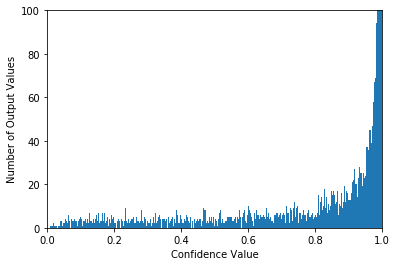

In [102]:
plt.hist(x, bins = 1000)
plt.xlabel('Confidence Value')
plt.ylabel('Number of Output Values')
axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([0,100])
plt.show()